# Multimodal Search on the Amazon Products Dataset

[Alex Klibisz](https://alexklibisz.com)  
November 12, 2020 

## Introduction

This tutorial will demonstrate how to implement multimodal search on an e-commerce dataset using native Elasticsearch functionality, as well as features only available in the Elastiknn plugin.

We'll work with data from the [_Amazon Products Dataset_](http://jmcauley.ucsd.edu/data/amazon/links.html), which contains product metadata, reviews, and image vectors for 9.4 million Amazon products. We'll focus specifically on the _clothing, shoes, and jewelry_ category, containing about 1.5 million products. This dataset was collected by researchers at UCSD. The image vectors were computed using a convolutional neural network. For more information, see the paper _Justifying recommendations using distantly-labeled reviews and fine-grained aspects_ by Jianmo Ni, Jiacheng Li, and Julian McAuley. 

To demonstrate multimodal search, we'll first search for products using keywords, then use nearest neighbors queries to find image vectors with high angular similarity (indicating similar appearance), and then combine the keyword and nearest-neighbor searches.

The tutorial is implemented using a Jupyter notebook. The source can be found in the `examples` directory in the [Elastiknn github project.](https://github.com/alexklibisz/elastiknn)

---

**Caveats**

1. This tutorial assumes you are comfortable with Python, the Elasticsearch JSON API, and nearest neighbor search. To modify and run it on your own, you'll need to [install Elastiknn](https://alexklibisz.github.io/elastiknn/installation/).
2. The purpose of this tutorial is not to offer a direct performance comparison. The query times are displayed, but they can vary pretty wildly across runs. The JVM is a tricky beast and any performance comparisons require many more samples. See the [Elastiknn performance docs](https://alexklibisz.github.io/elastiknn/performance/) for more details.
3. The purpose of this tutorial is also not necessarily to convince you that I've improved the search results by using image vectors. That's a larger problem that would, at the very least, require investigating how the vectors were computed. Rather, the purpose is to show the mechanics and patterns of integrating traditional keyword search with nearest neighbor search on a dataset of non-trivial size.  


---
## Download the Data

Download two files:

1. meta_Home_and_Kitchen.json.gz - contains the product metadata, about 270mb.
2. image_features_Home_and_Kitchen.b - contains the 4096-dimensional image vectors, about 23gb.

In [4]:
fname_products = "meta_Clothing_Shoes_and_Jewelry.json.gz"
fname_vectors = "image_features_Clothing_Shoes_and_Jewelry.b"

!wget -nc http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/{fname_products}
!wget -nc http://snap.stanford.edu/data/amazon/productGraph/image_features/categoryFiles/{fname_vectors}

!du -hs meta_Clothing_Shoes_and_Jewelry.json.gz
!du -hs image_features_Clothing_Shoes_and_Jewelry.b

File ‘meta_Clothing_Shoes_and_Jewelry.json.gz’ already there; not retrieving.

File ‘image_features_Clothing_Shoes_and_Jewelry.b’ already there; not retrieving.

268M	meta_Clothing_Shoes_and_Jewelry.json.gz
23G	image_features_Clothing_Shoes_and_Jewelry.b


---
## Explore the Data

Let's have a look at the data. We'll first import some helpers from the `amazonutils` module and several other common libraries.

In [33]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from amazonutils import *
from itertools import islice
from tqdm import tqdm
from pprint import pprint, pformat
from IPython.display import Image, display, Markdown, Code, HTML
import matplotlib.pyplot as plt
import numpy as np
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Now iterate over the metadata for a few products using the `iter_products` function. Each product is a dictionary containing a title, price, etc.

{'asin': '0456830197',
 'categories': [['Clothing, Shoes & Jewelry',
                 'Women',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses'],
                ['Clothing, Shoes & Jewelry',
                 'Men',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/21PGEX1t2pL.jpg',
 'salesRank': {'Shoes': 257607},
 'title': "NVC Unisex Light Weight Silver 'Dakota' Glasses Case with Brushed "
          'Metal Finish'}


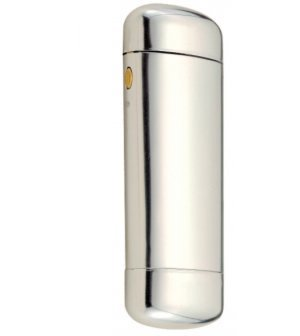

{'asin': '0456856293',
 'categories': [['Clothing, Shoes & Jewelry',
                 'Women',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses'],
                ['Clothing, Shoes & Jewelry',
                 'Men',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/31-NheYDxSL._SX395_.jpg',
 'salesRank': {'Shoes': 399415},
 'title': 'Kismeth Eyewear Classic Large Top Gun Aviator Sunglasses with Gold '
          'Frames &amp; Green Smoked Lenses'}


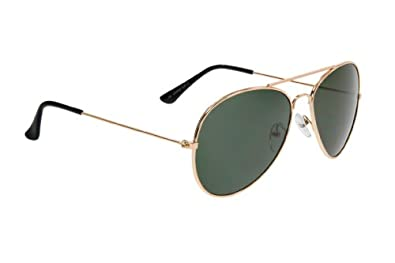

{'asin': '0456840532',
 'categories': [['Clothing, Shoes & Jewelry',
                 'Women',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses'],
                ['Clothing, Shoes & Jewelry',
                 'Men',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses'],
                ['Clothing, Shoes & Jewelry',
                 'Novelty, Costumes & More',
                 'Band & Music Fan',
                 'Accessories']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/11q4qGCdw3L.jpg',
 'salesRank': {'Clothing': 2728771},
 'title': 'Max-MPH Black - Large Wayfarer Sunglasses Available in Black with '
          'Extra Dark Lenses &amp; Black with Clear (No Strength) Lenses'}


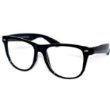

In [37]:
for p in islice(iter_products(fname_products), 5, 8):
  d = {k:v for (k,v) in p.items() if k not in {'related', 'description'}}
  pprint(d)
  display(Image(p['imUrl'], width=128, height=128))

Let's use the `iter_vectors` function to iterate over product IDs and image vectors. Each vector is just a list of 4096 floats, generated using a deep convolutional neural network. There is little value in inspecting the individual vectors, so we'll just show the vector length and first few values. 

In [5]:
for (asin, vec) in islice(iter_vectors(fname_vectors), 3):
  print(asin, len(vec), vec[:3])

B000IG9NS6 4096 [0.0, 0.608299970626831, 0.0]
B000FIPV42 4096 [0.0, 0.0, 0.0]
B000FZ1AO0 4096 [0.4043000042438507, 0.0, 4.453100204467773]


Let's sample a subset of vectors and plot the distribution of values. This will be more informative than inspecting individual vectors.

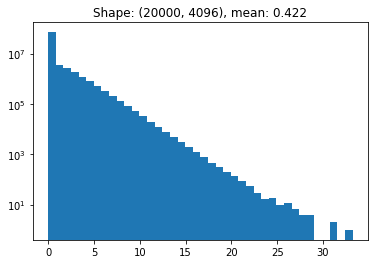

In [38]:
sample = np.array(
  [v for (_, v) in islice(iter_vectors(fname_vectors), 20000)]
)
plt.title("Shape: %s, mean: %.3f" % (sample.shape, sample.mean()))
plt.hist(np.ravel(sample), bins=40, log=True)
plt.show()

### Reduce Vector Dimensionality

The histogram above shows there are many zeros in the vectors. 

The zeros usually don't add much information when computing similarity, but they do occupy storage space, memory, and CPU. We should be able to reduce the dimensionality while preserving most of the information. Forgive my mathematical hand-waviness in discussing "information."

Another reason for reducing dimensionality is that Elasticsearch's native `dense_vector` datatype only supports vectors up to 2048 dimensions.

I included a simple dimensionality reduction technique in the function `iter_vectors_reduced`. It takes the file name, the desired `dims`, and a number of `samples`. It iterates over the first `samples` vectors in the given file name, maintaining a sum along each index. It then finds the `dims` indices with the largest sums and returns another generator function which produces vectors from a given file name, returning only the greatest indices based on the original sample.

Reducing the dimensionality from 4096 to 256 produces close to an order of magnitude fewer zeros and preserves enough information for our purposes.

B000IG9NS6 256 [5.9893999099731445, 0.0, 3.8183999061584473]
B000FIPV42 256 [4.293399810791016, 0.0, 3.595599889755249]
B000FZ1AO0 256 [2.1886000633239746, 1.9733999967575073, 12.249600410461426]


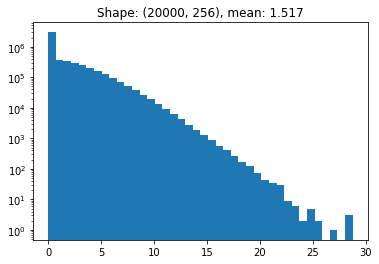

In [16]:
vector_dims = 256
reduced = iter_vectors_reduced(fname_vectors, dims=vector_dims, samples=10000)

for (asin, vec) in islice(reduced(fname_vectors), 3):
  print(asin, len(vec), vec[:3])

sample = np.array([v for (_, v) in islice(reduced(fname_vectors), 20000)])
plt.title("Shape: %s, mean: %.3f" % (sample.shape, sample.mean()))
plt.hist(np.ravel(sample), bins=40, log=True)
plt.show()

---
## Connect to Elasticsearch

In [14]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk

es = Elasticsearch(["http://localhost:9200"])
es.cluster.health(wait_for_status='yellow', request_timeout=1)

{'cluster_name': 'docker-cluster',
 'status': 'green',
 'timed_out': False,
 'number_of_nodes': 1,
 'number_of_data_nodes': 1,
 'active_primary_shards': 1,
 'active_shards': 1,
 'relocating_shards': 0,
 'initializing_shards': 0,
 'unassigned_shards': 0,
 'delayed_unassigned_shards': 0,
 'number_of_pending_tasks': 0,
 'number_of_in_flight_fetch': 0,
 'task_max_waiting_in_queue_millis': 0,
 'active_shards_percent_as_number': 100.0}

---
## Create the Elasticsearch Index

To recap, each product in our dataset has a dictionary of metadata and a 256-dimensional image vector.

Let's create an index and define a mapping that represents this.
The mapping has these properties:

|property|type|description|
|:--|:--|:--|
|asin|keyword|Unique product identifier.|
|imVecElastiknn|elastiknn_dense_float_vector|The image vector, stored using Elastiknn. We'll also use the Angular LSH model to support approximate nearest neighbor queries.|
|imVecXpack|dense_vector|The image vector, stored using the X-Pack dense_vector data type.|
|title|text||
|description|text||
|price|float||

We're including two vectors: one using the `dense_vector` datatype that comes with Elasticsearch (specificially X-Pack), the other using the `elastiknn_dense_float_vector` datatype provided by Elastiknn.

I've chosen to use Angular similarity for finding similar vectors (i.e. similarly-looking products). I made this choice by experimenting with L2 and Angular similarity and seeing better results with Angular similarity. The similarity function that works best for your vectors has a lot to do with how the vectors were computed. In this case, I don't know a lot about how the vectors were computed, so a bit of guess-and-check was required.

In [17]:
index = 'amazon-products'
source_no_vecs = ['asin', 'title', 'description', 'price', 'imUrl']

settings = {
  "settings": {
    "elastiknn": True,
    "number_of_shards": 1,
    "number_of_replicas": 0
  }
}

mapping = {
  "dynamic": False,
  "properties": {
    "asin": { "type": "keyword" },
    "imVecElastiknn": {
      "type": "elastiknn_dense_float_vector",
      "elastiknn": {
        "dims": vector_dims,
        "model": "lsh",
        "similarity": "angular",
        "L": 60,
        "k": 3
      }
    },
    "imVecXpack": {
      "type": "dense_vector",
      "dims": vector_dims
    },
    "title": { "type": "text" },
    "description": { "type": "text" },
    "price": { "type": "float" },
    "imUrl": { "type": "text" }
  }
}

if not es.indices.exists(index):
  es.indices.create(index, settings)
  es.indices.put_mapping(mapping, index)
es.indices.get_mapping(index)

{'amazon-products': {'mappings': {'dynamic': 'false',
   'properties': {'asin': {'type': 'keyword'},
    'description': {'type': 'text'},
    'imUrl': {'type': 'text'},
    'imVecElastiknn': {'type': 'elastiknn_dense_float_vector',
     'elastiknn': {'model': 'lsh',
      'similarity': 'angular',
      'dims': 256,
      'L': 60,
      'k': 3}},
    'imVecXpack': {'type': 'dense_vector', 'dims': 256},
    'price': {'type': 'float'},
    'title': {'type': 'text'}}}}}

---

## Index the Products

Now that we've created a new index with an appropriate mapping, we can index (store) the products.

We'll first iterate over the product data, using the `asin` property as the document ID and storing everything except the vectors. Then we'll iterate over the vectors separately to add a vector to each doc.

We'll call `refresh` and `forcemerge` after the initial product indexing and after the vector updates. This moves all the docs into a single Lucene segment, which helps ensure you get roughly the same query results each time you re-build the index.

The product indexing takes about 5 minutes and vector indexing about 45 minutes on my laptop.

In [10]:
def product_actions():
  for p in tqdm(iter_products(fname_products)):
    yield { 
      "_op_type": "index", "_index": index, "_id": p["asin"], 
      "asin": p["asin"], "title": p.get("title", None), 
      "description": p.get("description", None),
      "price": p.get("price", None),
      "imUrl": p.get("imUrl", None)
    }

bulk(es, product_actions(), chunk_size=2000, max_retries=2)

1503384it [03:47, 6618.64it/s]


(1503384, [])

In [11]:
es.indices.refresh(index=index)
es.indices.forcemerge(index=index, max_num_segments=1, request_timeout=120)

{'_shards': {'total': 1, 'successful': 1, 'failed': 0}}

In [12]:
reduced = iter_vectors_reduced(fname_vectors, vector_dims, 10000)

def vector_actions():
  for (asin, v) in tqdm(reduced(fname_vectors)):
    yield { "_op_type": "update", "_index": index, "_id": asin, 
            "doc": { 
              "imVecElastiknn": { "values": v },
              "imVecXpack": v
            }}

bulk(es, vector_actions(), chunk_size=50, max_retries=10, request_timeout=60)

1494171it [41:34, 599.03it/s]


(1494171, [])

In [13]:
es.indices.refresh(index=index)
es.indices.forcemerge(index=index, max_num_segments=1, request_timeout=300)

{'_shards': {'total': 1, 'successful': 1, 'failed': 0}}

---

## Start searching with a keyword query

Imagine you're shopping for a men's wrist watch on Amazon.

You'll start by matching a simple keyword query, _**men's watch**_, against the title and description.

Found 10000 hits in 24 ms. Showing top 5.

Title   Men's Watch
Desc    None
Price   519.97
ID      B004N43FEM
Score   14.299339


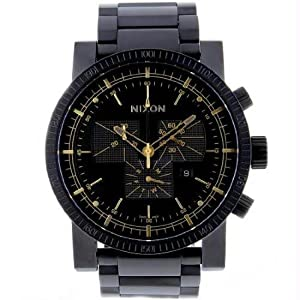


Title   Montreal Men's Watch [Watch] Lacoste
Desc    None
Price   89.99
ID      B008MNEF8K
Score   14.05599


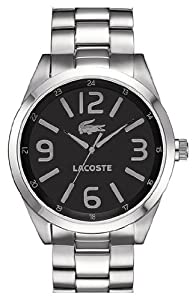


Title   Big Display Watch - Men's Watch
Desc    None
Price   9.99
ID      B007W1QEXC
Score   14.05599


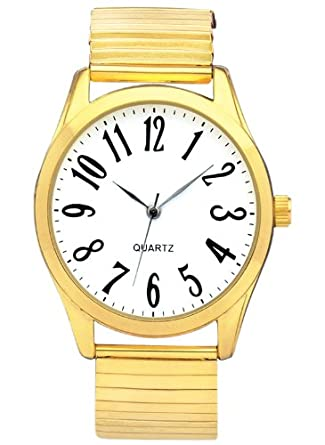


Title   Classic Men's Watch [Watch] Seiko
Desc    None
Price   None
ID      B000RHH6WQ
Score   14.05599


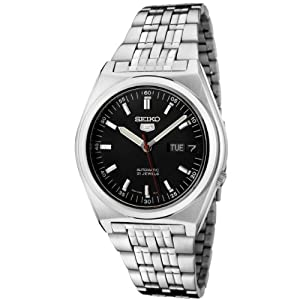


Title   Guess Men's Mens Watch Watch U11507G4
Desc    None
Price   None
ID      B00305A9YY
Score   13.507851


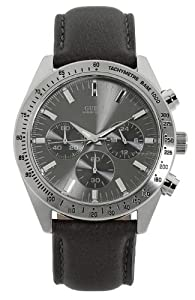

In [50]:
body = {
  "query": {
    "multi_match": {
      "query": "men's watch",
      "fields": ["title^2", "description"]
    }
  }
}

res = es.search(index=index, body=body, size=5, _source=source_no_vecs)
display_hits(res)

---
## Find similar-looking products using native Elasticsearch vector functionality

You really like the top result (ID `B004N43FEM`) and want to explore some similar-looking options.

We'll start by using native Elasticsearch functionality to do an exact nearest neighbors query. This compares a given vector against all vectors in the index.

This query consists of three steps:

1. Fetch the image vector for your favorite product.
2. Use the vector in a script-score query that computes the `cosineSimilarity` between the vector and a stored vector.
3. Execute the query. 

Note that the top result is the original product. You would typically filter this out in your application logic.

Found 10000 hits in 664 ms. Showing top 5.

Title   Men's Watch
Desc    None
Price   519.97
ID      B004N43FEM
Score   2.0


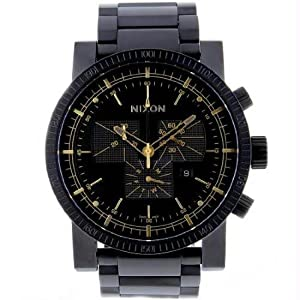


Title   GUESS Stainless Steel Waterpro Bracelet Watch
Desc    None
Price   None
ID      B000WUZIVY
Score   1.8572302


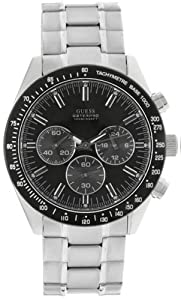


Title   Henley Gents Black Imitaton Chrono Sports Watch
Desc    None
Price   35.95
ID      B006497126
Score   1.8562803


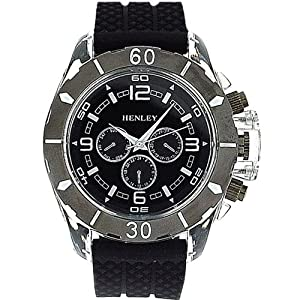


Title   Seiko Men's SGEE89P1 Stainless Steel Watch
Desc    None
Price   None
ID      B006KX74H8
Score   1.8523066


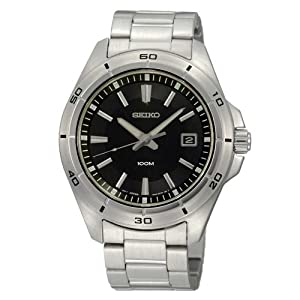


Title   Seiko Men's SSC225 Sport Solar Analog Display Japanese Quartz Black Watch
Desc    None
Price   210.0
ID      B00I6MB45E
Score   1.8414404


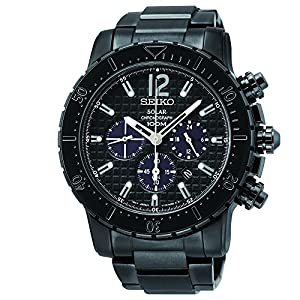

In [51]:
product_id = "B004N43FEM"

fetch_res = es.get(index=index, id=product_id)
query_vec = fetch_res['_source']['imVecElastiknn']['values']

body = {
  "query": {
    "script_score": {
      "query": { "match_all": {} },
      "script": {
        # If the `imVecXpack` vector is missing, just return 0. Else compute the similarity.
        "source": 'doc["imVecXpack"].size() == 0 ? 0 : 1.0 + cosineSimilarity(params.vec, "imVecXpack")',
        "params": {
          "vec": query_vec
        }
      }
    }
  }
}

res = es.search(index=index, body=body, size=5, _source=source_no_vecs)
display_hits(res)

---
## Find similar-looking products using Elastiknn's exact nearest neighbors query

Let's implement the same nearest_neighbors query using Elastiknn. You'll notice two differences compared to the previous query:

1. We reference the query vector using its document ID and the field containing the vector. This avoids a round trip request to fetch the vector.
2. We don't need to use a script. The whole query is simple JSON keys and values.

Note the results are identical to the native Elasticsearch query.

Found 10000 hits in 993 ms. Showing top 5.

Title   Men's Watch
Desc    None
Price   519.97
ID      B004N43FEM
Score   2.0


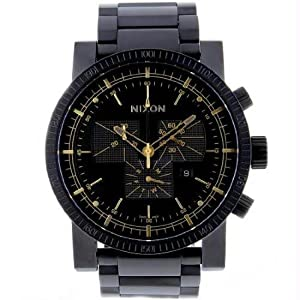


Title   GUESS Stainless Steel Waterpro Bracelet Watch
Desc    None
Price   None
ID      B000WUZIVY
Score   1.8572302


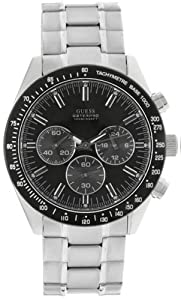


Title   Henley Gents Black Imitaton Chrono Sports Watch
Desc    None
Price   35.95
ID      B006497126
Score   1.8562803


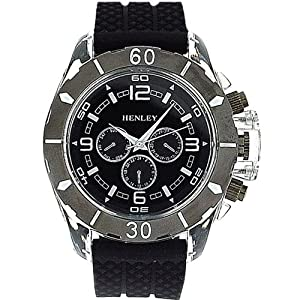


Title   Seiko Men's SGEE89P1 Stainless Steel Watch
Desc    None
Price   None
ID      B006KX74H8
Score   1.8523066


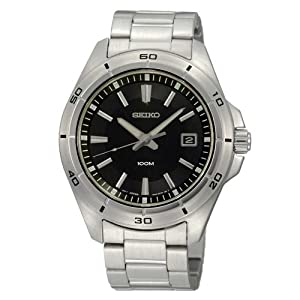


Title   Seiko Men's SSC225 Sport Solar Analog Display Japanese Quartz Black Watch
Desc    None
Price   210.0
ID      B00I6MB45E
Score   1.8414404


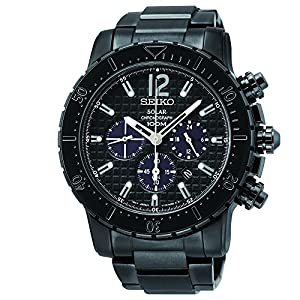

In [54]:
body = {
  "query": {
    "elastiknn_nearest_neighbors": {
      "vec": {
        "index": index,
        "id": product_id,
        "field": "imVecElastiknn"
      },
      "field": "imVecElastiknn",
      "model": "exact",
      "similarity": "angular"
    }
  }
}

res = es.search(index=index, body=body, size=5, _source=source_no_vecs)
display_hits(res)

---
## Find similar-looking products (faster) using Elastiknn's approximate query

Both of the previous queries take > 500ms. Each query scores _every_ vector in the index, so the runtime only increases as the index grows.

To address this, Elastiknn offers approximate nearest neighbors queries based on the [Locality Sensitive Hashing](https://en.wikipedia.org/wiki/Locality-sensitive_hashing) technique. 

We used the angular LSH model (i.e. `"model": "lsh", "similarity": "angular"`) when defining the mapping (right before indexing the data). Now we can use the same model and similarity to run an approximate nearest neighbors query. This query takes a `"candidates"` parameter, which is the number of approximate matches that will be re-ranked using the exact similarity score.

Using the approximate query with 100 candidates yields reasonable results in under 150 ms. 

You can tweak the mapping and query parameters to fine-tune the speed/recall tradeoff. The [API docs](https://alexklibisz.github.io/elastiknn/api/) include notes on how the parameters generally affect speed/recall, and the [Performance docs](https://alexklibisz.github.io/elastiknn/performance/) include suggested parameter settings for several datasets.

Found 100 hits in 140 ms. Showing top 5.

Title   Men's Watch
Desc    None
Price   519.97
ID      B004N43FEM
Score   2.0


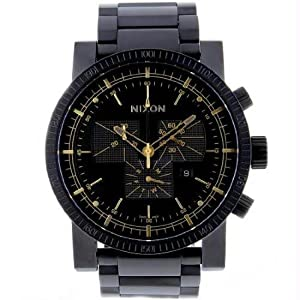


Title   Henley Gents Black Imitaton Chrono Sports Watch
Desc    None
Price   35.95
ID      B006497126
Score   1.8562803


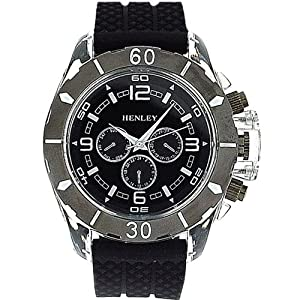


Title   Seiko Men's SNAE65 Sportura Chronograph Alarm Watch
Desc    None
Price   249.0
ID      B0057PA46S
Score   1.8403854


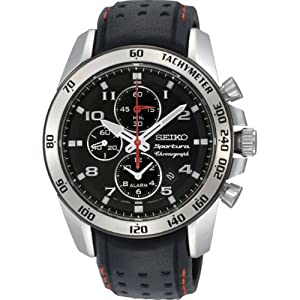


Title   Relic by Fossil Brady Chronograph Black Dial Mens Watch ZR66029
Desc    None
Price   39.95
ID      B005D0RVGS
Score   1.8385626


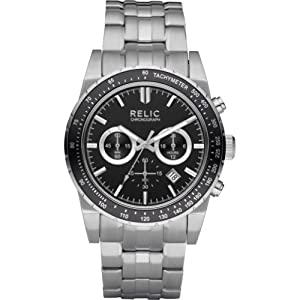


Title   Seiko Men's SSA008 Stainless Steel Analog with Black Dial Watch
Desc    None
Price   229.0
ID      B0074LAXE6
Score   1.8342296


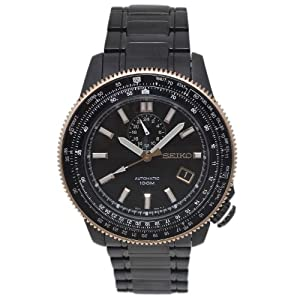

In [60]:
body = {
  "query": {
    "elastiknn_nearest_neighbors": {
      "vec": {
        "index": index,
        "field": "imVecElastiknn",
        "id": product_id
      },
      "field": "imVecElastiknn",
      "model": "lsh",
      "similarity": "angular",
      "candidates": 100
    }
  }
}

res = es.search(index=index, body=body, size=5, _source=source_no_vecs)
display_hits(res)

---
## Combine keyword and nearest neighbors queries using native Elasticsearch

The previous queries returned some nice results, but you decide you really want this watch to be blue.

To support this, we can combine a keyword query for "blue" with a nearest neighbors query for the original image vector.

Native Elasticsearch lets us do this by modifying the `query` clause in the `script_score` query.

Found 10000 hits in 45 ms. Showing top 5.

Title   Men's Solar Stainless Steel Case and Bracelet Chronograph Black Dial Blue Hour Markers
Desc    None
Price   231.94
ID      B008VGQLTY
Score   1.7925661


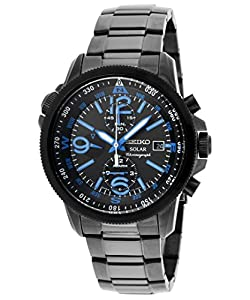


Title   Isobrite T100 Eclipse Watch Green, Blue &amp; Orange Tritium
Desc    None
Price   449.0
ID      B00DEGAJEO
Score   1.7646891


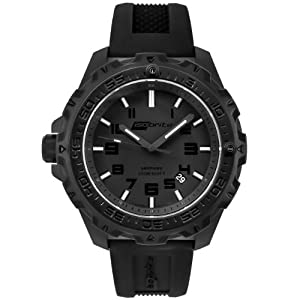


Title   Haurex Italy Men's 0A351UBB Aggressive Chrono Blue Dial Watch
Desc    None
Price   None
ID      B003OCF7MW
Score   1.7613895


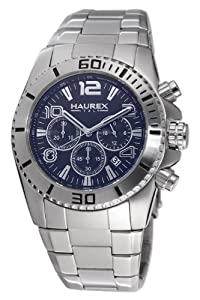


Title   Isobrite T100 Eclipse Watch Blue &amp; Orange Tritium
Desc    None
Price   449.0
ID      B00DEG5AJI
Score   1.7577422


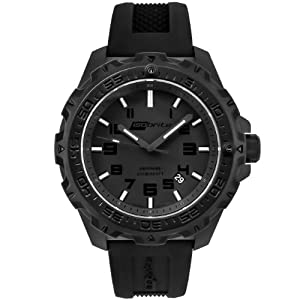


Title   Swiss Legend Men's 21046-BB-01-BBLAS Sprinter Analog Display Swiss Quartz Blue Watch
Desc    None
Price   68.71
ID      B00IS3J6ZG
Score   1.757721


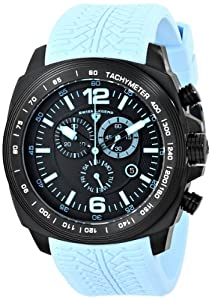

In [61]:
body = {
  "query": {
    "script_score": {
      "query": {
        "multi_match": {
          "query": "blue",
          "fields": ["title^2", "description"]
        }
      },
      "script": {
        "source": 'doc["imVecXpack"].size() == 0 ? 0 : 1.0 + cosineSimilarity(params.vec, "imVecXpack")',
        "params": {
          "vec": query_vec
        }
      }
    }
  }
}
res = es.search(index=index, body=body, size=5)
display_hits(res)

---
## Combine keyword and nearest neighbors queries using Elastiknn's exact query

We can do the same thing using a function score query containing an `elastiknn_nearest_neighbors` function. This function takes the exact same parameters as an `elastiknn_nearest_neighbors` query.

Note that the function score query gives you quite a bit more flexibility. Specifically, you can tweak the `boost_mode` parameter to control how the keyword and nearest neighbor queries are combined and tweak the `weight` to scale the nearest neighbor query score.

There are still some caveats, which are covered in the [API docs](https://alexklibisz.github.io/elastiknn/api/#using-a-function-score-query).

Found 10000 hits in 54 ms. Showing top 5.

Title   Men's Solar Stainless Steel Case and Bracelet Chronograph Black Dial Blue Hour Markers
Desc    None
Price   231.94
ID      B008VGQLTY
Score   3.5851321


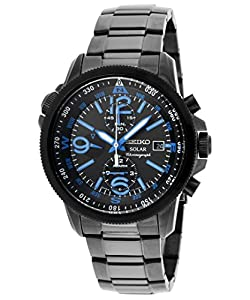


Title   Isobrite T100 Eclipse Watch Green, Blue &amp; Orange Tritium
Desc    None
Price   449.0
ID      B00DEGAJEO
Score   3.5293782


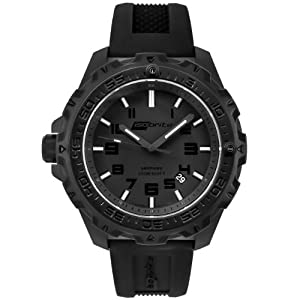


Title   Haurex Italy Men's 0A351UBB Aggressive Chrono Blue Dial Watch
Desc    None
Price   None
ID      B003OCF7MW
Score   3.522779


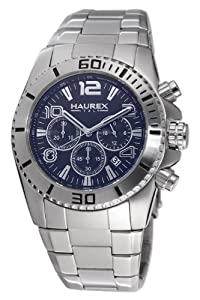


Title   Isobrite T100 Eclipse Watch Blue &amp; Orange Tritium
Desc    None
Price   449.0
ID      B00DEG5AJI
Score   3.5154846


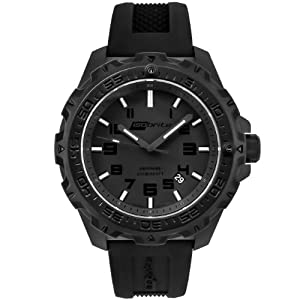


Title   Swiss Legend Men's 21046-BB-01-BBLAS Sprinter Analog Display Swiss Quartz Blue Watch
Desc    None
Price   68.71
ID      B00IS3J6ZG
Score   3.515442


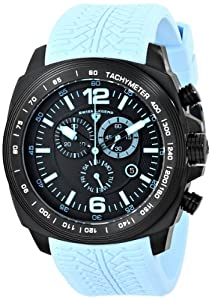

In [62]:
body = {
  "query": {
    "function_score": {
      "query": {
        "bool": {
          "filter": {
            "exists": {
              "field": "imVecElastiknn"
            }
          },
          "must": {
            "multi_match": {
              "query": "blue",
              "fields": ["title^2", "description"]
            }
          }
        }
      },
      "boost_mode": "replace",
      "functions": [{
        "elastiknn_nearest_neighbors": {
          "field": "imVecElastiknn",
          "similarity": "angular",
          "model": "exact",
          "vec": {
            "values": query_vec
          }
        },
        "weight": 2
      }]
    }
  }
}

res = es.search(index=index, body=body, size=5, _source=source_no_vecs)
display_hits(res)

---
## Combine keyword and nearest neighbors queries using Elastiknn's approximate query

The term "blue" occurs very frequently in a catalog of clothing, shoes, and jewelry. The queries above matched 10k docs for the term, and then evaluated exact nearest neighbors on those docs. In most cases, including this one, the exact query will be sufficiently fast when combined with a filter. If you encounter a case where that's not true, you can experiment with an approxiamte query, demonstrated below. The results won't always be faster, as there's some overhead in computing and matching hashes.

Found 10000 hits in 107 ms. Showing top 5.

Title   Fossil Men's Blue Watch BQ9325
Desc    None
Price   None
ID      B000RZAE7C
Score   2.2666667


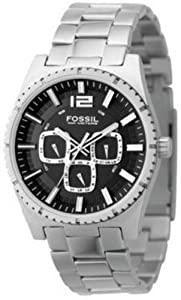


Title   National Geographic Men's NG712GSSU Pioneer Series Deep Blue Watch
Desc    None
Price   None
ID      B000WCGPFK
Score   2.1333334


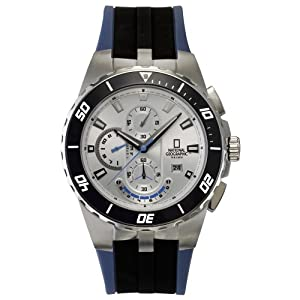


Title   Claude Bernard Men's 10203 3B BUIN Aquarider Blue Chronograph Tachymeter Rubber Watch
Desc    None
Price   None
ID      B006ZFF874
Score   2.1333334


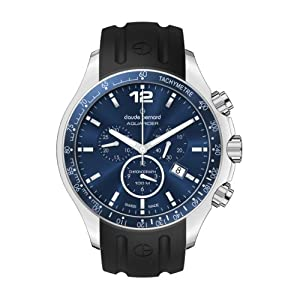


Title   Geneva Light Blue Silicon Link Band Quartz Men's Watch
Desc    None
Price   10.37
ID      B00F7LLOQG
Score   2.0666666


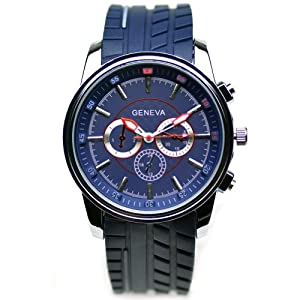


Title   TechnoMarine Men's 110021 Cruise Sport Chronograph Black and Blue Dial Watch
Desc    None
Price   None
ID      B003NRTBDO
Score   2.0666666


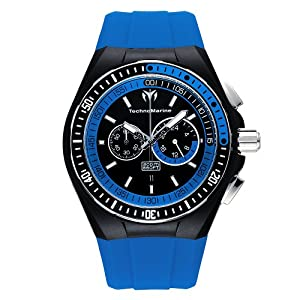

In [64]:
body = {
  "query": {
    "function_score": {
      "query": {
        "bool": {
          "filter": {
            "exists": {
              "field": "imVecElastiknn"
            }
          },
          "must": {
            "multi_match": {
              "query": "blue",
              "fields": ["title^2", "description"]
            }
          }
        }
      },
      "boost_mode": "replace",
      "functions": [{
        "elastiknn_nearest_neighbors": {
          "field": "imVecElastiknn",
          "similarity": "angular",
          "model": "lsh",
          "candidates": 100,
          "vec": {
            "values": query_vec
          }
        },
        "weight": 2
      }]
    }
  }
}

res = es.search(index=index, body=body, size=5, _source=source_no_vecs)
display_hits(res)